In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import warnings
warnings.filterwarnings('ignore')

# import libraries to set random_seed for CNN classification
from numpy.random import seed

import cv2
import PIL

# import ML/DL libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import utils, svm, metrics
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from tf_explain.core.grad_cam import GradCAM


from keras.preprocessing.image import ImageDataGenerator # used for image augmentation
from tensorflow.keras.applications.inception_v3 import preprocess_input


import tensorflow as tf
from tensorflow import keras
# used for building and training a new model
from keras import Sequential, Model, losses
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation
from keras.applications import VGG16, ResNet50, ResNet50V2, ResNet101
from classification_models.keras import Classifiers
# ResNet50, _ = Classifiers.get('resnet50')
# ResNet34, _ = Classifiers.get('resnet34')
from tf_explain.core.grad_cam import GradCAM

# import functions from other python files
from code_files.imagePreprocessing import * 

from sklearn.decomposition import PCA

Total number of images:  480


<AxesSubplot:ylabel='count'>

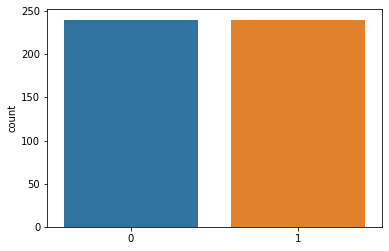

In [3]:
# ********************************
#           IMPORT IMAGES
# ********************************
# import images (and labels) and store in dataframe
# FLAG: set the path to the desired dataset
data_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/orig_raw/'  

trainImgs = pd.DataFrame()
trainArray = []

img_path = []
lbl = []
lblName = []
run_balanced=False
for group in os.listdir(data_path): # group = healthy or parkinsons
    # for img in os.listdir(os.path.join(data_path, group)):
        path = os.path.join(data_path, group) # add ,img to the end for original dataset


        # convert the image and store as a matrix
        drawing = cv2.imread(path)
        drawing = cv2.resize(drawing, (224,224))
        

        # store the labels
        if 'H' in group: #if group == 'healthy':
            if run_balanced:
                if len(lbl)-np.count_nonzero(lbl)<176:
                    lbl.append(0)
                    lblName.append('healthy')
                    trainArray.append(drawing)
                    img_path.append(path) 
            else:
                lbl.append(0)
                lblName.append('healthy')
                trainArray.append(drawing)
                img_path.append(path) 
        else:
            lbl.append(1)
            lblName.append('parkinsons')
            trainArray.append(drawing)
            img_path.append(path) 

        

trainLbls = lbl
trainImgs['image'] = img_path
trainImgs['label'] = lblName


# shuffle the data
# trainImgs, trainArray, trainLbls = utils.shuffle(trainImgs, trainArray, trainLbls)

# convert labels to categorical for training model
trainLbls_categorical = tf.keras.utils.to_categorical(trainLbls)
# print("Labels of first 5 images: \n", trainLbls_categorical[0:5])

# used in the feature extraction section
numImgs = len(trainLbls)
print("Total number of images: ", numImgs)

sns.countplot(trainLbls)

In [3]:
# ******************************
#         IMPORT MODEL
# ******************************
rs=42
seed(4)
tf.random.set_seed(2)

# import ResNet-50 pretrained model 
# ResNet50, preprocess_input = Classifiers.get('resnet34')
model = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3)) # setting include_top=False removes the fully connected layers of the model

# summarize feature map shapes # FLAG: can uncomment for feature visualization
all_blocks = []
for i in range(len(model.layers)):
    layer=model.layers[i]
    # check for conv layer
    if 'conv' in layer.name:
        # print(i, layer.name, layer.output.shape)
        all_blocks.append(i)

blocks = all_blocks 
output_layers = [model.layers[i].output for i in blocks]
# redefine model to output right after each conv layer
vis_model = Model(inputs=model.inputs, outputs=output_layers)
# vis_model = tf.keras.models.Model(model.inputs, model.get_layer('conv5_block3_out').output, model.output)
# vis_model.summary()
# model.summary()

# model_builder = keras.applications.ResNet50 #(weights='imagenet', include_top=True)
# # model_builder.summary()
# img_size=(224,224,3)
# preprocess_input = tf.keras.applications.resnet.preprocess_input
# # decode_predictions = tf.keras.applications.resnet.decode_predictions()

# last_conv_layer_name =  'conv5_block3_out' #'conv3_block4_out'

In [4]:
# GRAD CAM
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )
    x = GlobalAveragePooling2D(keepdims=False)(grad_model.output)
    prediction = Dense(2, activation='softmax')(x)
    grad_model = Model(inputs=grad_model.input, outputs=[grad_model.output, prediction])
    # grad_model.summary()

    pred = grad_model.predict(img_array, verbose=0)
    # pred = np.argmax(pred, axis=1)
    print("prediction: ", pred[1])
    pred_val = pred[1][0][0]

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_val

def save_and_display_gradcam(img_array, heatmap, pred_val, i, alpha=0.4):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)
    img = img_array[0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.figure(figsize=(5,5))
    plt.matshow(superimposed_img, fignum=1)
    plt.xticks([])
    plt.yticks([])
    if np.round(pred_val) == trainLbls[i]:
        color='red'
    else:
        color='green'
    plt.title('PD Pred: ' + str(np.around(1-pred_val,4)) + ' | Actual: ' + str(trainLbls[i]), color=color)
    # plt.show()

    save_name = 'img_' + str(i) + '_gradCAM.jpg'
    plt.savefig(save_name)
    plt.close()

In [ ]:
# GRAD CAM (attempt 2)
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )
    x = GlobalAveragePooling2D(keepdims=False)(grad_model.output)
    prediction = Dense(2, activation='softmax')(x)
    grad_model = Model(inputs=grad_model.input, outputs=[grad_model.output, prediction])
    # grad_model.summary()

    pred = grad_model.predict(img_array, verbose=0)
    # pred = np.argmax(pred, axis=1)
    print("prediction: ", pred[1])
    pred_val = pred[1][0][0]

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), pred_val

def save_and_display_gradcam(img_array, heatmap, pred_val, i, alpha=0.4):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)
    img = img_array[0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.figure(figsize=(5,5))
    plt.matshow(superimposed_img, fignum=1)
    plt.xticks([])
    plt.yticks([])
    if np.round(pred_val) == trainLbls[i]:
        color='red'
    else:
        color='green'
    plt.title('PD Pred: ' + str(np.around(1-pred_val,4)) + ' | Actual: ' + str(trainLbls[i]), color=color)
    # plt.show()

    save_name = 'img_' + str(i) + '_gradCAM.jpg'
    plt.savefig(save_name)
    plt.close()

# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------

model_builder = keras.applications.ResNet50 #(weights='imagenet', include_top=True)
img_size=(224,224,3)
preprocess_input = tf.keras.applications.resnet.preprocess_input

last_conv_layer_name =  'conv5_block3_out' #'conv3_block4_out'

for i in [0]:
    # img_array = preprocess_input(get_img_array(img_path, size=img_size))
    img_array = np.array([trainArray[i]]).astype(np.double)
    img_array = preprocess_input(img_array)

    # Make model
    model = model_builder(weights='imagenet')
    # model.summary()

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    # preds = model.predict(img_array)
    # print("Predicted:", decode_predictions(preds, top=1)[0])
    # print(preds)

    # Generate class activation heatmap
    heatmap, pred_val = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    # plt.matshow(heatmap)
    # plt.show()

    save_and_display_gradcam(img_array, heatmap, np.around(pred_val,4), i)

In [ ]:
# Prepare image
seed(1)
tf.random.set_seed(1)
imgs = np.arange(0,50,1)

model_builder = keras.applications.ResNet50 #(weights='imagenet', include_top=True)
img_size=(224,224,3)
preprocess_input = tf.keras.applications.resnet.preprocess_input

last_conv_layer_name =  'conv5_block3_out' #'conv3_block4_out'

for i in [0]:
    # img_array = preprocess_input(get_img_array(img_path, size=img_size))
    img_array = np.array([trainArray[i]]).astype(np.double)
    img_array = preprocess_input(img_array)

    # Make model
    model = model_builder(weights='imagenet')
    # model.summary()

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    # preds = model.predict(img_array)
    # print("Predicted:", decode_predictions(preds, top=1)[0])
    # print(preds)

    # Generate class activation heatmap
    heatmap, pred_val = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    # plt.matshow(heatmap)
    # plt.show()

    save_and_display_gradcam(img_array, heatmap, np.around(pred_val,4), i)

In [ ]:
# ******************************
#     VISUALIZE FEATURE MAPS
# ******************************
# choose second conv block from each layer to display
blocks = [174] #all_blocks #, 12, 21, 24, 31, 34, 41, 44] #[4, 38, 78, 140, 172]
output_layers = [model.layers[i].output for i in blocks]
# redefine model to output right after each conv layer
vis_model = Model(inputs=model.inputs, outputs=output_layers)
# vis_model = tf.keras.models.Model(model.inputs, model.get_layer('conv5_block3_out').output, model.output)
vis_model.summary()

# train_feat, test_feat, train_lbls, test_lbls = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)

# select images to save visualizations for and put them in an array
# manually choose two healthy and two parkinsons
for k in range(1):
    img2vis = np.array([trainArray[k]]).astype(np.double) # , test_feat[1]]

    # iterate through each image and save the feature maps
    for i in range(len(img2vis)):
        img = np.expand_dims(img2vis[i], axis=0)
        img = preprocess_input(img)
        feature_maps = vis_model.predict(img)

        # tf_y = tf.convert_to_tensor(np.expand_dims(data[0,:,:,:],axis=0))
        # tf_x = tf.convert_to_tensor(img2vis, dtype=np.float32)
        # loss = losses.categorical_crossentropy(tf_y, model(tf_x))
        # grad = tf.GradientTape(loss, tf_x)
        # with tf.GradientTape() as tape:
        #     last_conv_layer_output, preds = vis_model(img)
        #     print(last_conv_layer_output)
        #     pred_index=tf.argmax(preds[0])
        #     class_channel = preds[:,pred_index]

        
        blocknum = 0
        hmaps = np.zeros((224,224))
        # perform the linear combination of feature maps
        block_num = 0
        for fmap in feature_maps:
            lin_comb = (np.zeros(np.shape(fmap[0,:,:,0]))).astype(np.uint8)
            for i in range(np.shape(fmap)[3]):
                temp = fmap[0,:,:,i] #* 255.0
                # temp = temp - np.abs(np.min(temp)) # adjust the minimum to be zero
                # temp = temp / np.max(temp) # normalize maximum to be 1
                lin_comb = cv2.add(lin_comb,temp.astype(np.uint8))

            # perform global average pooling to obtain {alpha_k}^c - neuron importance weights
            neur_weight_gap = np.average(lin_comb)

            # lin_comb = lin_comb / np.shape(fmap)[3]

            # print(blocks[block_num])
            lin_comb = lin_comb * neur_weight_gap
            lin_comb = cv2.resize(lin_comb, (224, 224))
            hmaps += lin_comb

            # plt.matshow(lin_comb)
            # plt.show()
            block_num+=1
    
        img_gray = (img2vis[0,:,:,0] + img2vis[0,:,:,1] + img2vis[0,:,:,2]) / 3
        heatmap = cv2.cvtColor((hmaps / np.max(hmaps)).astype(np.float32), cv2.COLOR_GRAY2RGB)
        plt.figure()
        plt.matshow(hmaps)
        plt.show()

# for fmap_inner in feature_maps:
#     fmap_size = np.shape(fmap_inner)

#     # determine the number of images to plot
#     if fmap_size[3]==64:
#         rows=8;cols=8
#     elif fmap_size[3]==128:
#         rows=16; cols=8
#     elif fmap_size[3]==256:
#         rows=16;cols=16
#     else:
#         rows=16;cols=32

#     itr = 1
#     fig, ax = plt.subplots(rows,cols, figsize=(75,75))
#     title = 'Image_' + str(i) + 'fmap: ' + str(np.shape(fmap_inner))
#     fig.suptitle(title)

#     for r in range(rows):
#         for c in range(cols):
#             ax[r][c].imshow(fmap_inner[0,:,:,itr-1], cmap='gray')
#             itr += 1

#     plt.tight_layout()
#     savename = 'Image_' + str(i) + '_block_' +  str(blocks[blocknum]) + '_rn101.png'
#     print(savename)
#     fig.savefig(savename)
#     plt.close()
#     blocknum += 1

In [86]:
# ******************************************************************************************************
# ------------------------------------------------------------------------------------------------------
#                                           CLASSIFICATION  
# ------------------------------------------------------------------------------------------------------
# ******************************************************************************************************

# 1. VGG16 or RestNet50
# 2. SVM
# 3. Naive Bayes
# 4. Random Forest
seed(4)
tf.random.set_seed(2)

model_builder = keras.applications.ResNet101 #(weights='imagenet', include_top=True)
img_size=(224,224,3)
preprocess_input = tf.keras.applications.resnet.preprocess_input

last_conv_layer_name = 'conv5_block3_out' #'block5_conv3'

model = model_builder(weights='imagenet')
# model.summary()
model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )
# model.summary()
score_model = model

# x = GlobalAveragePooling2D(keepdims=False)(grad_model.output)
# prediction = Dense(2, activation='softmax')(x)
# model_top = Model(inputs=grad_model.input, outputs=[grad_model.output])
# grad_model = Model(inputs=grad_model.input, outputs=[grad_model.output, prediction])
# grad_model.summary()

# .........................
#    FEATURE EXTRACTION
# .........................
# define a function that will extract the features from conv network
def extract_features(imgs, num_imgs):
    datagen = ImageDataGenerator(rescale=1./255) # define to rescale pixels in image
    batch_size = 32
    
    features = np.zeros(shape=(num_imgs, 7,7,2048)) # shape equal to output of convolutional base 
    lbls = np.zeros(shape=(num_imgs,2))

    # preprocess data
    generator = datagen.flow_from_dataframe(imgs, x_col = 'image', y_col='label', target_size=(224,224), class_mode='categorical', batch_size=batch_size, shuffle=False)

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        lbls[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_imgs:
            break
    return features, lbls

# extract features for both the trainImgs and testImgs
data, labels = extract_features(trainImgs, numImgs)

Found 480 validated image filenames belonging to 2 classes.
1/1 [==============================] - 11s 11s/step


In [75]:
def ScoreCam(score_model, model, img_array, pred, test_feat, max_N=-1): #(pred, test_feat)

    cls = pred
    act_map_array = np.expand_dims(test_feat, axis=0)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = score_model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array).astype(np.float32)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = (score_model.predict(masked_input_array))
    pred_from_masked_input_array = softmax(model.predict(pred_from_masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

Loss:  0.46719059348106384 | Accuracy:  0.8125
Test Image #:  0
2/2 [==============================] - 0s 5ms/step
Prediction:  0
Test Label:  [1. 0.]
1/1 [==============================] - 0s 44ms/step


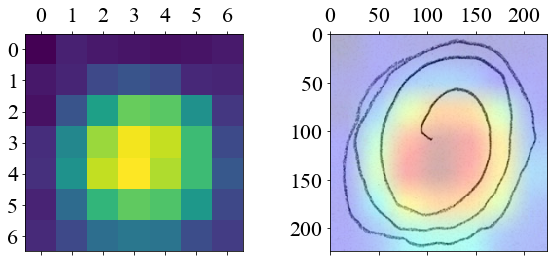

In [87]:
# score-cam (attempt #1) - 3/15/2023
def run_visualization(data, labels):

    seed(4)
    tf.random.set_seed(2)
    
    #set random seed
    rs=42
    # seed(rs)
    # tf.random.set_seed(rs)

    train_feat, test_feat, train_lbls, test_lbls = train_test_split(data, labels, test_size=0.1, random_state=rs, stratify=labels)
    _, test_feat_array, _, _ = train_test_split(trainArray, labels, test_size=0.1, random_state=rs, stratify=labels)
    # train pre-trained features
    # evaluate on VGG16 classifier (using cross validation)
    # define a function that will fit the model
    def defineModel(size): # size is the dimension of the last layer in the pretrained model
        model = Sequential()
        model.add(GlobalAveragePooling2D(input_shape=(size,size,2048)))
        # global average pooling is used instead of fully connected layers on top of the feature maps
        # it takes the average of each feature map and the resulting layer is fed directly into the softmax layer
        model.add(Dense(2, 'softmax'))
        # model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)  # use the Adam optimizer and set an effective learning rate 
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        return model


    def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, epochs):
        model = None
        model = defineModel(7) # FLAG: need to set the size based on the last layer
        trained_model = model.fit(train_feat, train_lbls, batch_size=32, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt, verbose=0)

        # testScore = model.evaluate(test_feat, test_lbls)
        return trained_model

    def importModel(filename, test_data, test_lbl):
        modelPath = filename
        testModel = tf.keras.models.load_model(modelPath)
        return testModel

    # train with k-fold validation
    model_history = []
    epochs = 250

    rs=42 # set the random state
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    i = 1
    for train, val in cv.split(train_feat, train_lbls[:,1]):
        print('Fold: ', i, end='\r')

        # split data into training and validation
        x_train = train_feat[train]
        x_val   = train_feat[val]
        y_train = train_lbls[train]
        y_val   = train_lbls[val]

        # define model checkpoint callback
        ckpt_name = '20230315_folador_orig_raw_fold' + str(i) + '.h5'
        model_chkpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, verbose=0, save_best_only=True)
    
        kfold_model = fit_and_evaluate(x_train, y_train, x_val, y_val, epochs=epochs)
        model_history.append(kfold_model)
        model = importModel(ckpt_name, test_feat, test_lbls)

        loss, accuracy = model.evaluate(np.array(test_feat), test_lbls, verbose=0)
        print("Loss: ", loss, "| Accuracy: ", accuracy)

        # RUN Score-CAM
        # *****************************
        total_number_test_imgs = len(test_feat)
        for timg in range(1):
            print('Test Image #: ', timg)
            pred = np.argmax(model.predict(np.array(test_feat))[timg])
            print('Prediction: ', pred)
            img_array = np.expand_dims(test_feat_array[timg], axis=0)
            print('Test Label: ', test_lbls[timg])
        
            cam = ScoreCam(score_model, model, img_array, pred, np.array(test_feat[timg]),max_N=10)
            # plt.matshow(cam)
            # plt.show()

            # heatmap = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
            # heatmap = np.uint8(255 * heatmap)
            # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            # # plt.imshow(heatmap)
            # # plt.show()
            
            # hif = .8
            # superimposed_img = heatmap * hif + test_feat_array[timg]
            # superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
            # superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
            # plt.matshow(superimposed_img_rgb)
            # plt.show()
            heatmap = np.uint8(255 * cam)

            # Use jet colormap to colorize heatmap
            jet = cm.get_cmap("jet")

            # Use RGB values of the colormap
            jet_colors = jet(np.arange(256))[:, :3]
            jet_heatmap = jet_colors[heatmap]

            # Create an image with RGB colorized heatmap
            jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
            jet_heatmap = jet_heatmap.resize( (img_array.shape[2], img_array.shape[1]))
            jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

            # Superimpose the heatmap on original image
            superimposed_img = jet_heatmap * 0.4 + test_feat_array[timg]
            superimposed_img_rgb = keras.preprocessing.image.array_to_img(superimposed_img)

            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
            ax1.matshow(cam)
            ax2.matshow(superimposed_img_rgb)
            # *****************************

        break
        i+=1

    return 

run_visualization(data, labels)

In [ ]:
# do grad cam
def rn50_gradcam(data, labels, classifier, features):

    plot_model_history=False
    seed(4)
    tf.random.set_seed(2)
    
    #set random seed
    rs=42
    # seed(rs)
    # tf.random.set_seed(rs)

    train_feat, test_feat, train_lbls, test_lbls = train_test_split(data, labels, test_size=0.1, random_state=rs, stratify=labels)
    _, test_feat_array, _, _ = train_test_split(trainArray, labels, test_size=0.1, random_state=rs, stratify=labels)
    # train pre-trained features
    # evaluate on VGG16 classifier (using cross validation)
    # define a function that will fit the model
    def defineModel(size): # size is the dimension of the last layer in the pretrained model
        model = Sequential()
        model.add(GlobalAveragePooling2D(input_shape=(size,size,2048)))
        # global average pooling is used instead of fully connected layers on top of the feature maps
        # it takes the average of each feature map and the resulting layer is fed directly into the softmax layer
        model.add(Dense(2, 'softmax'))
        model.summary()

        opt = tf.keras.optimizers.Adam(learning_rate=1e-3)  # use the Adam optimizer and set an effective learning rate 
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        return model


    def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, epochs):
        model = None
        model = defineModel(7) # FLAG: need to set the size based on the last layer
        trained_model = model.fit(train_feat, train_lbls, batch_size=32, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt, verbose=0)

        # testScore = model.evaluate(test_feat, test_lbls)
        return trained_model

    def importModel(filename, test_data, test_lbl):
        modelPath = filename
        testModel = tf.keras.models.load_model(modelPath)

        # # confusion matrix
        # cfm = confusion_matrix(label_pred, pred)
        # # print(cfm)

        # tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
        # tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

        return testModel

    # train with k-fold validation
    model_history = []
    epochs = 250

    rs=42 # set the random state
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)

    acc = []
    cfm_storage = []
    tpr_storage = []
    tnr_storage = []
    prec = []
    recall = []
    f1 = []

    i = 1
    # plt.figure(figsize=(8,8))
    for train, val in cv.split(train_feat, train_lbls[:,1]):
        print('Fold: ', i, end='\r')

        # split data into training and validation
        x_train = train_feat[train]
        x_val   = train_feat[val]
        y_train = train_lbls[train]
        y_val   = train_lbls[val]

        # define model checkpoint callback
        ckpt_name = '20230105_folador_skel_bal_raw_fold' + str(i) + '.h5'
        model_chkpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, verbose=0, save_best_only=True)
    
        kfold_model = fit_and_evaluate(x_train, y_train, x_val, y_val, epochs=epochs)
        model_history.append(kfold_model)
        model = importModel(ckpt_name, test_feat, test_lbls)

        loss, accuracy = model.evaluate(np.array(test_feat), test_lbls, verbose=0)
        print("Loss: ", loss, "| Accuracy: ", accuracy)

        # ROC curve
        probas_ = model.predict(np.array(test_feat)).ravel()
        # compute the ROC curve and area under the curve

        # RUN GRAD CAM
        # *****************************
        def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
            # Load the original image
            img = img_array

            # Rescale heatmap to a range 0-255
            heatmap = np.uint8(255 * heatmap)

            # Use jet colormap to colorize heatmap
            jet = cm.get_cmap("jet")

            # Use RGB values of the colormap
            jet_colors = jet(np.arange(256))[:, :3]
            jet_heatmap = jet_colors[heatmap]

            # Create an image with RGB colorized heatmap
            jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
            jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
            jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

            # Superimpose the heatmap on original image
            superimposed_img = jet_heatmap * alpha + img
            superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

            plt.matshow(superimposed_img)
            plt.show()

        for j in range(10):
            print('test image: ', j)
            test_imgs_to_visualize = [test_feat[j]]
            x_tensor = tf.convert_to_tensor(test_imgs_to_visualize, dtype=tf.float32)
            with tf.GradientTape() as t:
                t.watch(x_tensor)
                output = model(x_tensor)
            print(output)
            gradients = t.gradient(output, x_tensor)

            if np.array(gradients).any() != 0:
                pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))

                # We multiply each channel in the feature map array
                # by "how important this channel is" with regard to the top predicted class
                # then sum all the channels to obtain the heatmap class activation
                last_conv_layer_output = x_tensor[0]
                heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
                heatmap = tf.squeeze(heatmap)

                # For visualization purpose, we will also normalize the heatmap between 0 & 1
                heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

                save_and_display_gradcam(test_feat_array[2], heatmap)

        # *****************************

        fpr, tpr, thresholds = metrics.roc_curve(test_lbls.ravel(), probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0]=0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        # plt.plot(fpr, tpr, lw=1, alpha=0.3)

        # classification report
        pred = model.predict(np.array(test_feat))
        pred = np.argmax(pred, axis=1)
        label_pred = np.argmax(test_lbls, axis=1)
        # # print(classification_report(label_pred, pred))

        cfm = confusion_matrix(label_pred, pred)
        clf_report  = metrics.classification_report(label_pred, pred, output_dict=True)

        # calculate accuracy
        acc.append(accuracy)
    
        cfm_storage.append(cfm)
        tpr_storage.append(cfm[0][0] / (cfm[0][0] + cfm[1][0]))
        tnr_storage.append(cfm[1][1] / (cfm[1][1] + cfm[0][1]))
        prec.append(clf_report['macro avg']['precision'])
        recall.append(clf_report['macro avg']['recall'])
        f1.append(clf_report['macro avg']['f1-score'])

        i+=1

    # plt.plot([0,1],[0,1], linestyle='--', lw=2, color='k', label='Baseline', alpha=0.8)

    # mean_tpr = np.mean(tprs, axis=0)
    # mean_tpr[-1] = 1.0
    # mean_auc = metrics.auc(mean_fpr, mean_tpr)
    # std_auc = np.std(aucs)
    # plt.plot(mean_fpr, mean_tpr, color='b',
    #         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    #         lw=2, alpha=.8)

    # std_tpr = np.std(tprs, axis=0)
    # tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    # tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
    #                 label=r'$\pm$ 1 std. dev.')


    # if features==0: 
    #     plot_title = classifier + ' - $Orig$'
    # elif features==1:
    #     plot_title = classifier + ' - $Skel_U$'
    # else:
    #     plot_title = classifier + ' - $Skel_B$'

    # plt.xlim([-0.05, 1.05])
    # plt.ylim([-0.05, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend(loc="lower right")
    # plt.grid()
    # plt.title(plot_title, loc='left', fontweight='bold')
    # plt.rcParams.update({'font.size': 22})
    # plt.rcParams.update({'font.family': 'Times New Roman'})
    # plt.show()

    return acc, cfm, tpr_storage, tnr_storage, prec, recall, f1, model_history # also return model_history if running RN50

fcl_acc, fcl_cfm, fcl_tpr, fcl_tnr, fcl_prec, fcl_recall, fcl_f1, model_history = rn50_gradcam(data, labels, 'SVM', 0)
print(np.around(fcl_acc,4))
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_acc), np.max(fcl_acc), np.mean(fcl_acc), np.std(fcl_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_tpr), np.max(fcl_tpr), np.mean(fcl_tpr), np.std(fcl_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_tnr), np.max(fcl_tnr), np.mean(fcl_tnr), np.std(fcl_tnr)))
print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_prec), np.max(fcl_prec), np.mean(fcl_prec), np.std(fcl_prec)))
print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_recall), np.max(fcl_recall), np.mean(fcl_recall), np.std(fcl_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_f1), np.max(fcl_f1), np.mean(fcl_f1), np.std(fcl_f1)))

<AxesSubplot:ylabel='count'>

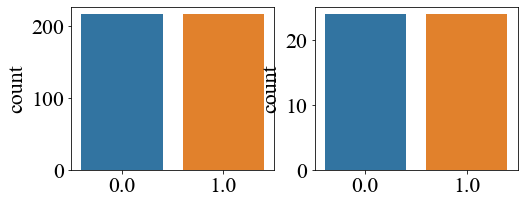

In [71]:
# =============================
#       Train on Fully Connected Layers
# =============================
# split into training and testing data
rs=42
train_feat, test_feat, train_lbls, test_lbls = train_test_split(data, labels, test_size=0.1, random_state=rs, stratify=labels)
# trainArray, testArray, _,_ = train_test_split(trainArray, trainLbls, test_size=0.1, random_state=rs, stratify=trainLbls)

fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(train_lbls[:,1], ax=ax[0])
sns.countplot(test_lbls[:,1], ax=ax[1])

In [72]:
def raw_feature_classification(data, labels, classifier, features):

    plot_model_history=False
    seed(4)
    tf.random.set_seed(2)
    
    if classifier=='NN':
        #set random seed
        rs=42
        # seed(rs)
        # tf.random.set_seed(rs)

        train_feat, test_feat, train_lbls, test_lbls = train_test_split(data, labels, test_size=0.1, random_state=rs, stratify=labels)
        # train pre-trained features
        # evaluate on VGG16 classifier (using cross validation)
        # define a function that will fit the model
        def defineModel(size): # size is the dimension of the last layer in the pretrained model
            model = Sequential()
            model.add(GlobalAveragePooling2D(input_shape=(size,size,2048)))
            # global average pooling is used instead of fully connected layers on top of the feature maps
            # it takes the average of each feature map and the resulting layer is fed directly into the softmax layer
            model.add(Dense(2, activation='softmax'))
            # model.summary()

            opt = tf.keras.optimizers.Adam(learning_rate=1e-3)  # use the Adam optimizer and set an effective learning rate 
            model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

            return model


        def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, epochs):
            model = None
            model = defineModel(7) # FLAG: need to set the size based on the last layer
            trained_model = model.fit(train_feat, train_lbls, batch_size=32, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt, verbose=0)

            # testScore = model.evaluate(test_feat, test_lbls)
            return trained_model

        def importModel(filename, test_data, test_lbl):
            modelPath = filename
            testModel = tf.keras.models.load_model(modelPath)

            # # confusion matrix
            # cfm = confusion_matrix(label_pred, pred)
            # # print(cfm)

            # tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
            # tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

            return testModel

        # train with k-fold validation
        model_history = []
        epochs = 250

        rs=42 # set the random state
        cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    else:
        # no need for validation data, just need train and test
        train_feat = data
        train_lbls = labels

        rs=42 # set the random state
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    if classifier=='SVM':
        param_grid={'C':[100],'degree':[7],'kernel':['poly']}
        clf = svm.SVC(kernel='poly', C=100, degree=7, probability=True, random_state=rs)

    if classifier == 'RF':
        param_grid = {'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth' : [10], 'criterion' :['gini'], 'random_state': [10]}
        clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=10, criterion='gini', random_state=rs)

    if classifier == 'NB':
        clf = GaussianNB(var_smoothing=1e-15)    

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)

    acc = []
    cfm_storage = []
    tpr_storage = []
    tnr_storage = []
    prec = []
    recall = []
    f1 = []

    i = 1
    plt.figure(figsize=(8,8))
    for train, val in cv.split(train_feat, train_lbls[:,1]):
        print('Fold: ', i, end='\r')

        if classifier=='NN':
            # split data into training and validation
            x_train = train_feat[train]
            x_val   = train_feat[val]
            y_train = train_lbls[train]
            y_val   = train_lbls[val]

            # define model checkpoint callback
            ckpt_name = '20230316_orig_raw_rn50_fold' + str(i) + '.h5'
            model_chkpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, verbose=0, save_best_only=True)
        
            kfold_model = fit_and_evaluate(x_train, y_train, x_val, y_val, epochs=epochs)
            model_history.append(kfold_model)
            model = importModel(ckpt_name, test_feat, test_lbls)

            loss, accuracy = model.evaluate(np.array(test_feat), test_lbls, verbose=0)
            print("Loss: ", loss, "| Accuracy: ", accuracy)

            # ROC curve
            probas_ = model.predict(np.array(test_feat)).ravel()
            # compute the ROC curve and area under the curve

            fpr, tpr, thresholds = metrics.roc_curve(test_lbls.ravel(), probas_)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0]=0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3)

            # classification report
            pred = model.predict(np.array(test_feat))
            pred = np.argmax(pred, axis=1)
            label_pred = np.argmax(test_lbls, axis=1)
            # # print(classification_report(label_pred, pred))

            cfm = confusion_matrix(label_pred, pred)
            clf_report  = metrics.classification_report(label_pred, pred, output_dict=True)

        else:
            # split data into training and validation
            x_train = train_feat[train]
            x_test  = train_feat[val]
            y_train = train_lbls[train]
            y_test  = train_lbls[val]

            # need to reshape data
            x_train_flat = []
            for i in range(len(x_train)):
                x_train_flat.append(x_train[i,:,:,:].flatten())
            x_train=x_train_flat

            x_test_flat = []
            for i in range(len(x_test)):
                x_test_flat.append(x_test[i,:,:,:].flatten())
            x_test=x_test_flat

            probas_ = clf.fit(x_train, y_train[:,1]).predict_proba(x_test)

            fpr, tpr, thresholds = metrics.roc_curve(y_test[:,1], probas_[:,1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0]=0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3)

            # classification report
            pred = clf.predict(np.array(x_test))

            accuracy = round(metrics.accuracy_score(y_test[:,1], pred),4)
            cfm = confusion_matrix(y_test[:,1], pred)
            clf_report  = metrics.classification_report(y_test[:,1], pred, output_dict=True)

        # calculate accuracy
        acc.append(accuracy)
    
        cfm_storage.append(cfm)
        tpr_storage.append(cfm[0][0] / (cfm[0][0] + cfm[1][0]))
        tnr_storage.append(cfm[1][1] / (cfm[1][1] + cfm[0][1]))
        prec.append(clf_report['macro avg']['precision'])
        recall.append(clf_report['macro avg']['recall'])
        f1.append(clf_report['macro avg']['f1-score'])

        i+=1

    plt.plot([0,1],[0,1], linestyle='--', lw=2, color='k', label='Baseline', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')


    if features==0: 
        plot_title = classifier + ' - $Orig$'
    elif features==1:
        plot_title = classifier + ' - $Unbal$'
    else:
        plot_title = classifier + ' - $Bal$'

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.title(plot_title, loc='left', fontweight='bold')
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.family': 'Times New Roman'})
    plt.show()

    # plot model
    if plot_model_history:
        # plot the accuracy and loss functions for each fold
        color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']

        for i in range(8):
            plt.figure(figsize=(10,10))
            plot_title = 'Accuracy: k-fold = ' + str(i+1)
            plt.title(plot_title)
            plt.plot(model_history[i].history['accuracy'], label='train acc', color=color[i])
            plt.plot(model_history[i].history['val_accuracy'], label='val acc', linestyle= ':', color=color[i])
            plt.axis([-10,epochs, .2, 1.1])
            plt.legend()
            plt.show()
        
        
        for i in range(8):
            plt.figure(figsize=(10,10))
            plt.plot(model_history[i].history['loss'], label='train loss', color=color[i])
            plt.plot(model_history[i].history['val_loss'], label='val loss', linestyle= ':', color=color[i])
            plt.axis([-10,epochs, .0, 1.1])
            plt.legend()
            plt.show()

    return acc, cfm, tpr_storage, tnr_storage, prec, recall, f1, model_history # also return model_history if running RN50

Loss:  0.3943815529346466 | Accuracy:  0.8541666865348816
2/2 [==============================] - 0s 8ms/step
Loss:  0.3691338300704956 | Accuracy:  0.8958333134651184
2/2 [==============================] - 0s 10ms/step
Loss:  0.38713112473487854 | Accuracy:  0.8541666865348816
2/2 [==============================] - 0s 4ms/step
Loss:  0.3711491525173187 | Accuracy:  0.8958333134651184
2/2 [==============================] - 0s 6ms/step
Loss:  0.39857450127601624 | Accuracy:  0.8541666865348816
2/2 [==============================] - 0s 7ms/step
Loss:  0.37916913628578186 | Accuracy:  0.8958333134651184
2/2 [==============================] - 0s 4ms/step
Loss:  0.399120956659317 | Accuracy:  0.8541666865348816
2/2 [==============================] - 0s 10ms/step
Loss:  0.38327905535697937 | Accuracy:  0.8541666865348816
2/2 [==============================] - 0s 10ms/step


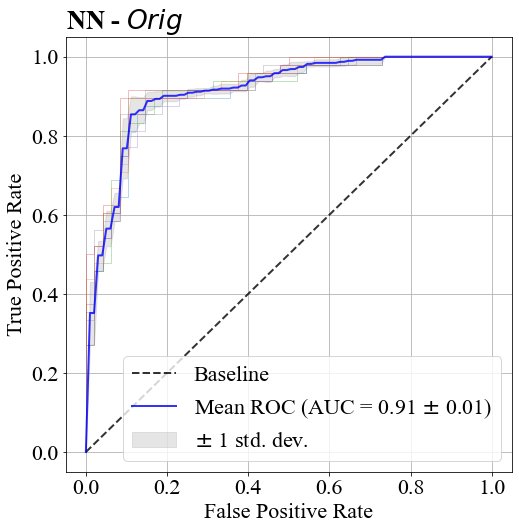

[0.8542 0.8958 0.8542 0.8958 0.8542 0.8958 0.8542 0.8542]
& 0.854 & 0.896 & 0.870$\pm$0.020 & 0.793 & 0.880 & 0.834$\pm$0.037 & 0.905 & 0.947 & 0.919$\pm$0.017 & 0.853 & 0.896 & 0.869$\pm$0.021


In [73]:
fcl_acc, fcl_cfm, fcl_tpr, fcl_tnr, fcl_prec, fcl_recall, fcl_f1, model_history = raw_feature_classification(data, labels, 'NN', 0)
print(np.around(fcl_acc,4))
print('& %0.3f & %0.3f & %0.3f$\pm$%0.3f & %0.3f & %0.3f & %0.3f$\pm$%0.3f & %0.3f & %0.3f & %0.3f$\pm$%0.3f & %0.3f & %0.3f & %0.3f$\pm$%0.3f' % \
     (np.min(fcl_acc), np.max(fcl_acc), np.mean(fcl_acc), np.std(fcl_acc), np.min(fcl_tpr), np.max(fcl_tpr), np.mean(fcl_tpr), np.std(fcl_tpr), \
      np.min(fcl_tnr), np.max(fcl_tnr), np.mean(fcl_tnr), np.std(fcl_tnr), np.min(fcl_f1), np.max(fcl_f1), np.mean(fcl_f1), np.std(fcl_f1)))
# print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_prec), np.max(fcl_prec), np.mean(fcl_prec), np.std(fcl_prec)))
# print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_recall), np.max(fcl_recall), np.mean(fcl_recall), np.std(fcl_recall)))
# print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % ())

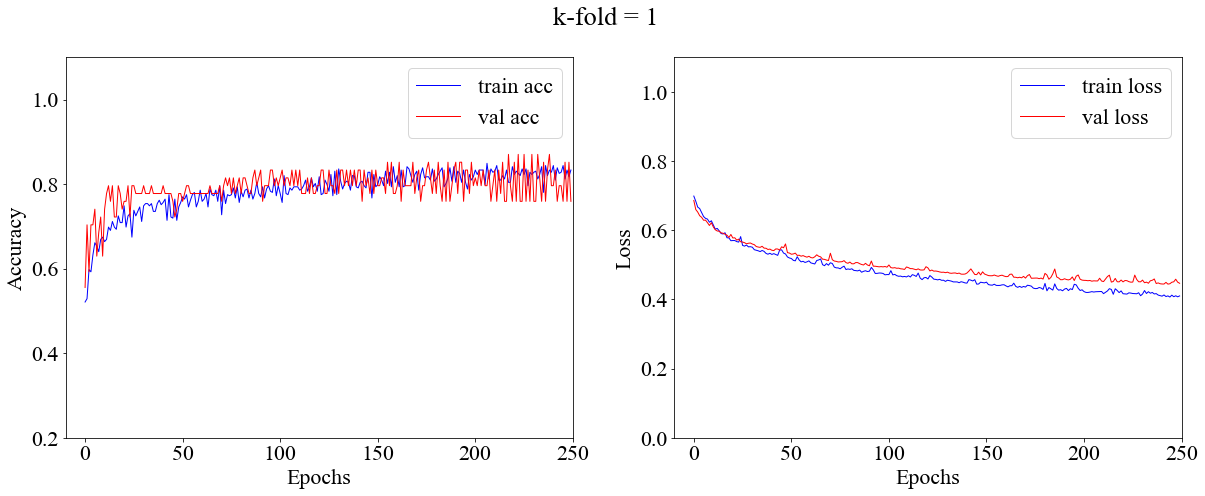

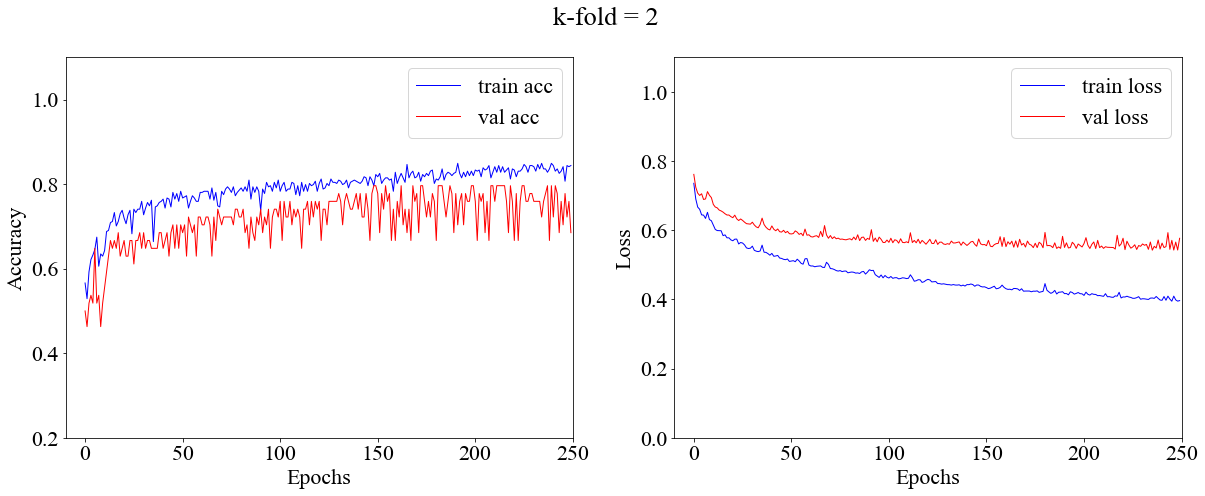

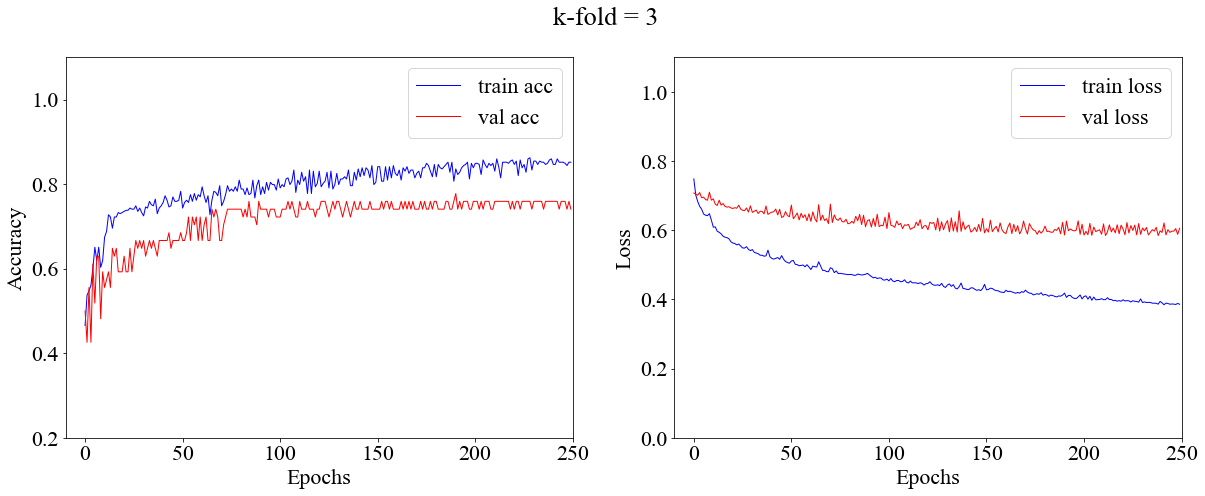

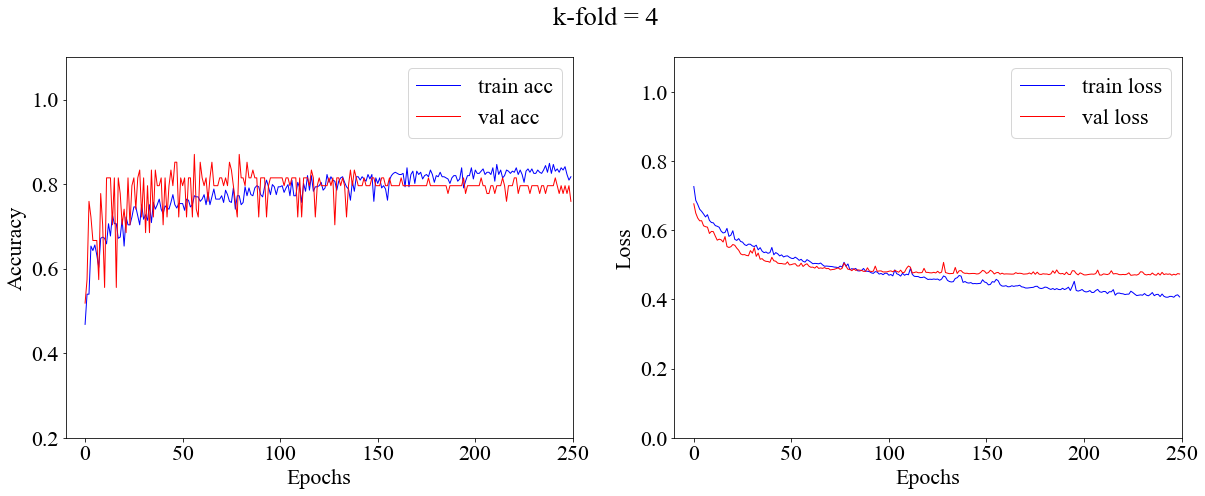

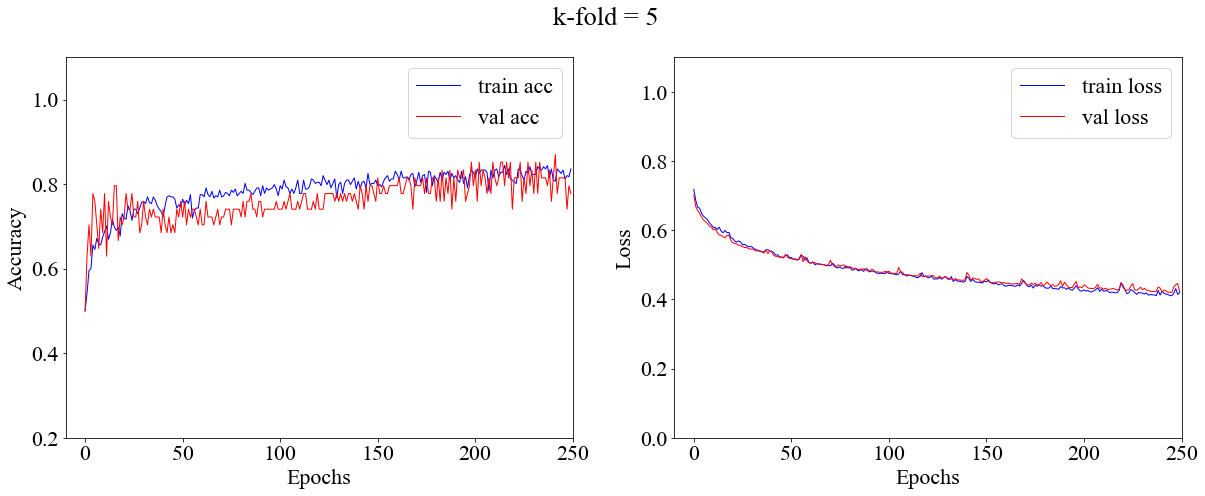

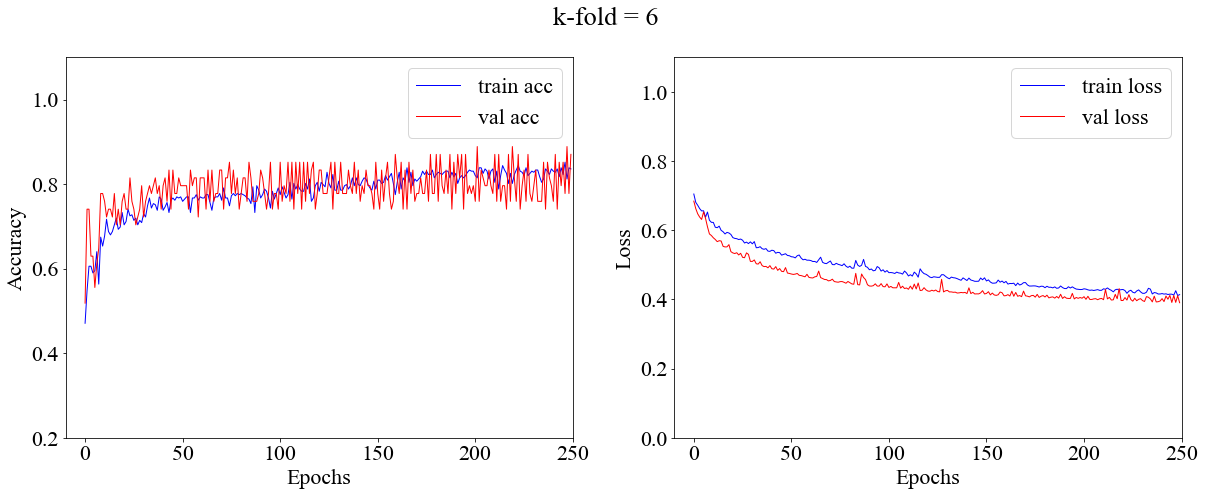

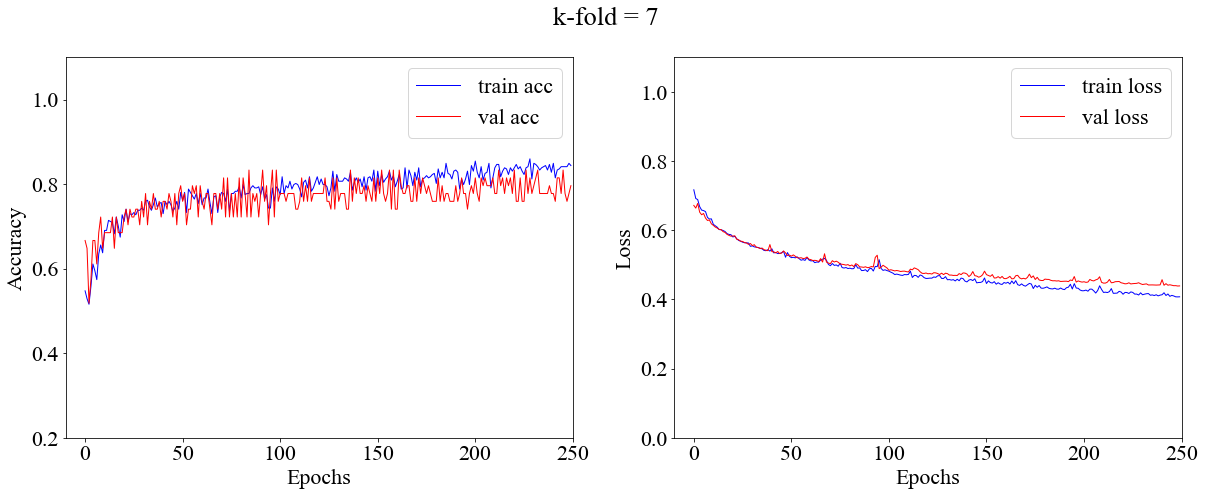

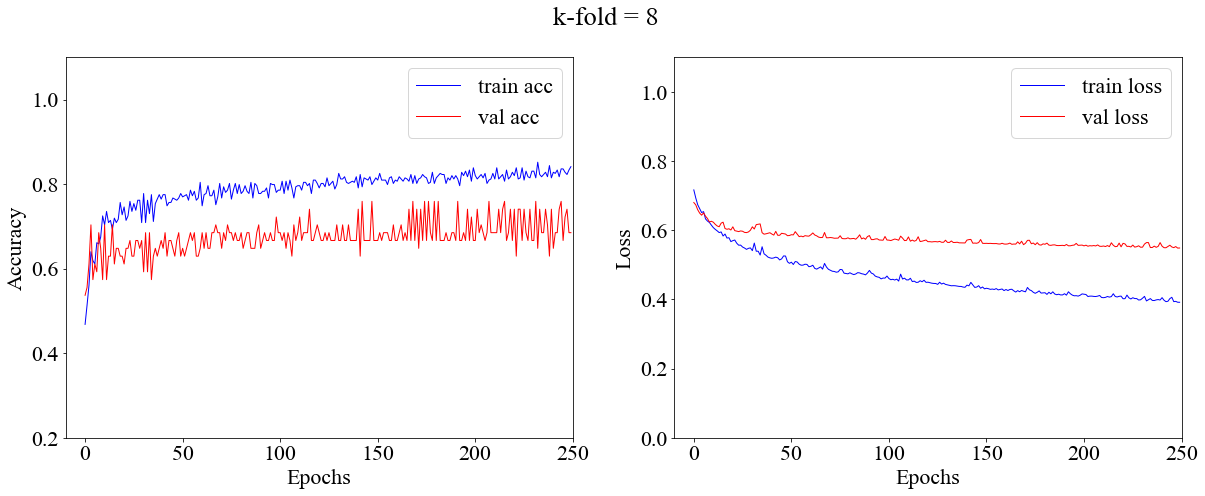

In [74]:
# color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']

for i in range(8):
    f, ax = plt.subplots(1, 2, figsize=(20,7))
    plot_title = 'k-fold = ' + str(i+1)
    f.suptitle(plot_title)
    ax[0].plot(model_history[i].history['accuracy'], label='train acc', color='blue', linewidth=1)
    ax[0].plot(model_history[i].history['val_accuracy'], label='val acc', color='red', linewidth=1)
    ax[0].axis([-10,250, .2, 1.1])
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()

    ax[1].plot(model_history[i].history['loss'], label='train loss', color='blue', linewidth=1)
    ax[1].plot(model_history[i].history['val_loss'], label='val loss', color='red', linewidth=1)
    ax[1].axis([-10,250, .0, 1.1])
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    save_name = 'rn50_k-fold_' + str(i+1) + '_.jpg'
    f.savefig(save_name)

In [8]:
# ...............
# VIEW RESULTS
# ...............   

new_model = False # FLAG

num_val_samples = int(np.ceil(len(trainArray) * 0.20))
k = int(np.floor(len(trainArray) / num_val_samples))

if new_model==True:
    # plot the accuracy and loss functions for each fold
    color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']
    f, ax = plt.subplots(2, k, figsize=(35,6))
    for i in range(k):
        ax[0][i].plot(model_history[i].history['accuracy'], label='train acc', color=color[i])
        ax[0][i].plot(model_history[i].history['val_accuracy'], label='val acc', linestyle= ':', color=color[i])
        ax[0][i].axis([-10,epochs, .2, 1.1])
        ax[0][i].legend()

        subplot_title = 'k = ' + str(i+1)
        ax[0][i].title.set_text(subplot_title)

    for i in range(k):
        ax[1][i].plot(model_history[i].history['loss'], label='train loss', color=color[i])
        ax[1][i].plot(model_history[i].history['val_loss'], label='val loss', linestyle= ':', color=color[i])
        ax[1][i].axis([-10,epochs, .0, 1.1])
        ax[1][i].legend()

# ---------------------------------
#   LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=0)
    print("Loss: ", loss, "| Accuracy: ", acc)

    # classification report
    pred = testModel.predict(np.array(testAug))
    pred = np.argmax(pred, axis=1)
    label_pred = np.argmax(testAugLabel, axis=1)
    print(classification_report(label_pred, pred))

    # confusion matrix
    cmat = confusion_matrix(label_pred, pred)
    print(cmat)


    return testModel

# load existing model and evaluate the test data
testmodel = importModel('20221219_kfold_folador_orig_bs32_rs10.h5', test_feat, test_lbls)

3/3 - 0s - loss: 0.3884 - accuracy: 0.8438 - 106ms/epoch - 35ms/step
Loss:  0.3883879482746124 | Accuracy:  0.84375
3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        48
           1       0.85      0.83      0.84        48

    accuracy                           0.84        96
   macro avg       0.84      0.84      0.84        96
weighted avg       0.84      0.84      0.84        96

[[41  7]
 [ 8 40]]


### Grad-CAM

In [66]:
# ***************************
#          GradCAM
# ***************************

# split into same training and testing sets as was trained on (random_state=42)
train_feat, test_feat, train_lbls, test_lbls = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)
# trainArray, testArray, _,_ = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)
def run_gradcam(model, img, class_index, fname, layer_name):
    img = tf.keras.preprocessing.image.img_to_array(img)
    data = ([img], None)
    explainer = GradCAM()
    grid = explainer.explain(data, model, class_index=class_index, layer_name=layer_name)
    explainer.save(grid, ".", fname)
    #return explainer


test_imgs_to_visualize = [test_feat[4], test_feat[5], test_feat[9], test_feat[11]] # first image is PD, second = healthy

layer2 = 'block2_conv1'
layer5 = 'block5_conv3'
flag_orig = True  # True if contains ST
model_orig = tf.keras.models.load_model('20230105_folador_skel_bal_raw_fold1.h5')
model_HT = tf.keras.models.load_model('20230105_folador_skel_bal_raw_fold2.h5') # ST removed
if (flag_orig):
    model = model_orig
    inc_HT = ''
else:
    model = model_HT
    inc_HT = '_HT_'

run_gradcam(model, test_imgs_to_visualize[0], class_index=1, fname='gradcam_img4_orig_'+inc_HT+'block2_rs42.png', layer_name=layer2)
run_gradcam(model, test_imgs_to_visualize[0], class_index=1, fname='gradcam_img4_orig_'+inc_HT+'block5_rs42.png', layer_name=layer5)
run_gradcam(model, test_imgs_to_visualize[1], class_index=1, fname='gradcam_img5_orig_'+inc_HT+'block2_rs42.png', layer_name=layer2)
run_gradcam(model, test_imgs_to_visualize[1], class_index=1, fname='gradcam_img5_orig_'+inc_HT+'block5_rs42.png', layer_name=layer5)
run_gradcam(model, test_imgs_to_visualize[2], class_index=1, fname='gradcam_img9_orig_'+inc_HT+'block2_rs42.png', layer_name=layer2)
run_gradcam(model, test_imgs_to_visualize[2], class_index=1, fname='gradcam_img9_orig_'+inc_HT+'block5_rs42.png', layer_name=layer5)
run_gradcam(model, test_imgs_to_visualize[3], class_index=1, fname='gradcam_img11_orig_'+inc_HT+'block2_rs42.png', layer_name=layer2)
run_gradcam(model, test_imgs_to_visualize[3], class_index=1, fname='gradcam_img11_orig_'+inc_HT+'block5_rs42.png', layer_name=layer5)

ValueError: No such layer: block2_conv1. Existing layers are: ['global_average_pooling2d_86', 'dense_86'].